In [337]:
# import what we need
import nltk
from nltk.stem.lancaster import LancasterStemmer ## used to stem words
import tensorflow
import random
import json # used to read in json file
stemmer = LancasterStemmer()

import numpy as np
import tensorflow.keras as keras

# printing 
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline


In [338]:
# load json file
with open("new_Intent.json") as file:
    data = json.load(file)

In [339]:
# view our json data
data['intents']

[{'tag': 'CurrentHumanQuery',
  'patterns': ['What is my name?',
   'What do you call me?',
   'Who do you think I am?',
   'What do you think I am?',
   'Who are you talking to?',
   'What name do you call me by?',
   'Tell me my name'],
  'responses': ['You are <HUMAN>! How can I help?',
   'Your name is  <HUMAN>, how can I help you?',
   'They call you <HUMAN>, what can I do for you?',
   'Your name is <HUMAN>, how can I help you?',
   '<HUMAN>, what can I do for you?'],
  'extension': {'function': 'extensions.gHumans.getCurrentHuman',
   'entities': False,
   'responses': ['You are %%HUMAN%%! How can I help?',
    'Your name is  %%HUMAN%%, how can I help you?',
    'They call you %%HUMAN%%, what can I do for you?',
    'Your name is %%HUMAN%%, how can I help you?',
    '%%HUMAN%%, what can I do for you?']},
  'context': {'in': '', 'out': 'CurrentHumanQuery', 'clear': False},
  'entityType': 'NA',
  'entities': []},
 {'tag': 'NameQuery',
  'patterns': ['What is your name?',
   'What

In [340]:
words = []
labels = []

docs_x = []
docs_y = [] 

# loop through dict to grab our values
for intent in data['intents']:
    for pattern in intent['patterns']:
        # stemming get the root of word, when traiing model 
        # only care abt the main meaning of word
        # need to tokenize/split words
        wrds = nltk.word_tokenize(pattern)
        words.extend(wrds) ## add all wrds to list
        docs_x.append(wrds)
        # for each pattern add another item in this var to track what tag its part of
        # each entry in docs_x (tokenized words/wrds) will correspond to (intent) docs_y so we know how to classify
        # each of the patterns
        docs_y.append(intent['tag'])
        
        if intent['tag'] not in labels:
            labels.append(intent['tag']) # grab all diff tags we need

In [341]:
# stem words and remove duplicate words. also lower all words so dont confuse the network into 
# thinking spelling case has different meaning
words = [stemmer.stem(w.lower()) for w in words if w!= '?' ] # remove any Question marks, dont want this
words = sorted(list(set(words)))                             # to have any meaning to our model
# sort the labels also 
labels = sorted(labels)

In [342]:
# prepare data before we feed into the model 

# need to convert our text in lists to nums (One-hot-encoding) so our network can 
# categorize the data
training = [] # input data goes here 
output = [] 

out_empty = [0 for _ in range(len(labels))]

for x, doc in enumerate(docs_x):
    
    bag = [] # will be our bag of one hot encoded words
    wrds = [stemmer.stem(w) for w in doc] # stem all the words in patterns
    
    # go through all diff words in list that are stemmed
    # and add either 1 or 0 to bag of words depending on if this word is in the 
    # main words list "(words = sorted(list(set(words))))"
    for w in words:
        # if word here place 1 representing that word exists
        if w in wrds:
            bag.append(1)
        else:
            # word isn't here place 0
            bag.append(0)
    
    # now generate output that has either 0's or 1's representing the tag that is word
    output_row = out_empty[:]
    # will look through labels list and check where tag is in list and set that value to 1 
    # in the output_row 
    output_row[labels.index(docs_y[x])] = 1
    
    # now we have both lists that are now One-hot-encoded !!
    training.append(bag)
    output.append(output_row)


In [343]:
# turn lists into numpy array
training = np.array(training)
output = np.array(output)


In [344]:
# shape of output
output.shape

In [345]:
# shape of training
training.shape

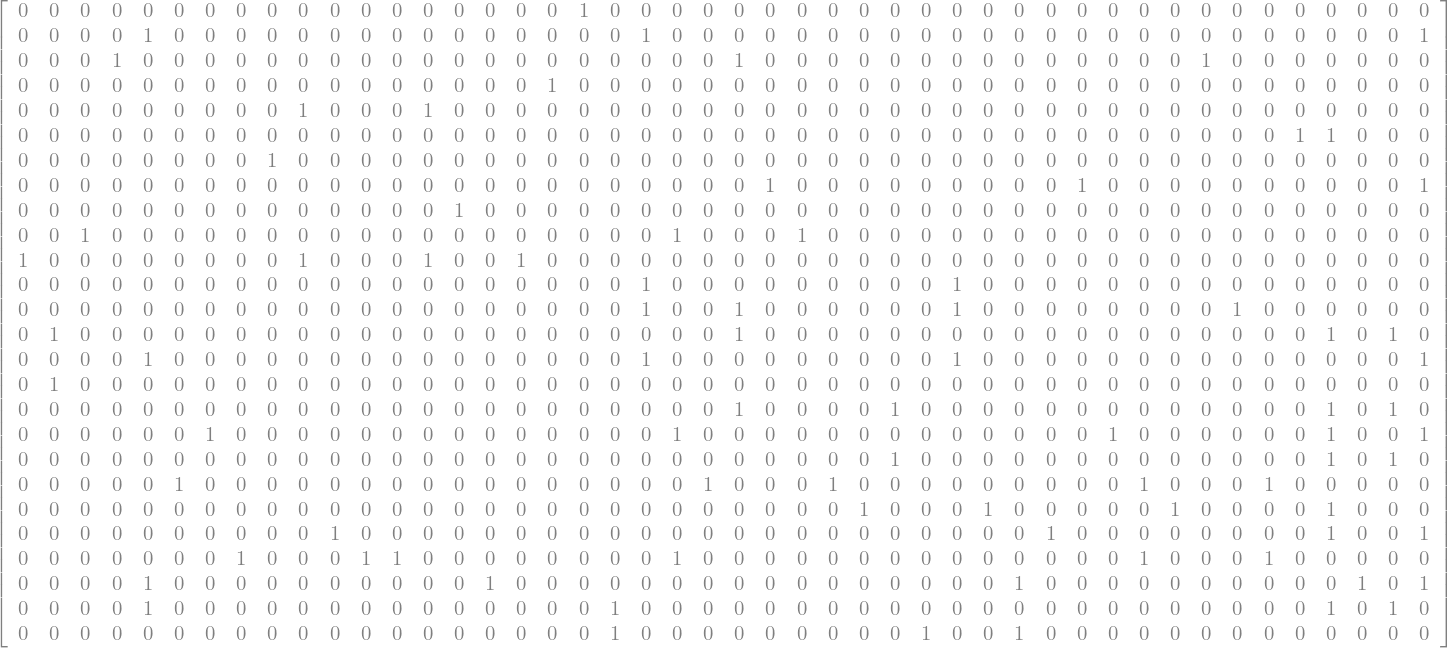

In [258]:
display(sp.Matrix(training))

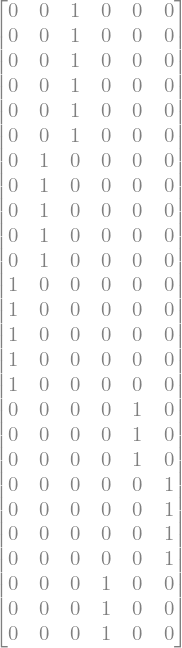

In [259]:
display(sp.Matrix(output))

In [349]:
# Multi-layer net with ReLU hidden layer

model = keras.models.Sequential()


model.add(keras.layers.Dense(8,input_dim=training.shape[1],activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))

model.add(keras.layers.Dense(8,activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))

model.add(keras.layers.Dense(8,activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))





# Output layer (size 6), softmax activation function
model.add(keras.layers.Dense(output.shape[1],activation='softmax'))

In [350]:
# Compile as above (default learning rate and other
# hyperparameters for the Adam optimizer).
# default learning rate for adam optimizer is 0.001

model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Nadam(learning_rate=0.001),
 metrics=[keras.metrics.CategoricalAccuracy()])

# Display the model
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 8)                 1096      
_________________________________________________________________
dense_136 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_137 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_138 (Dense)            (None, 32)                288       
Total params: 1,528
Trainable params: 1,528
Non-trainable params: 0
_________________________________________________________________


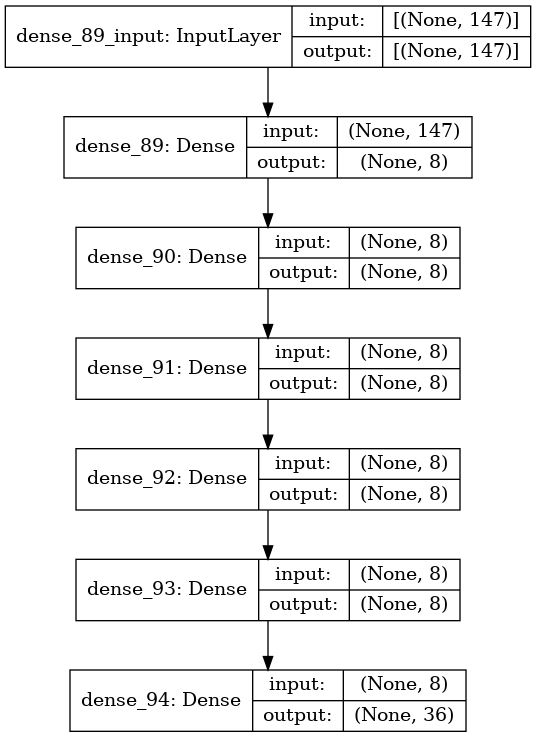

In [312]:
keras.utils.plot_model(model,to_file='chatbot.png',
 show_shapes=True,expand_nested=True)

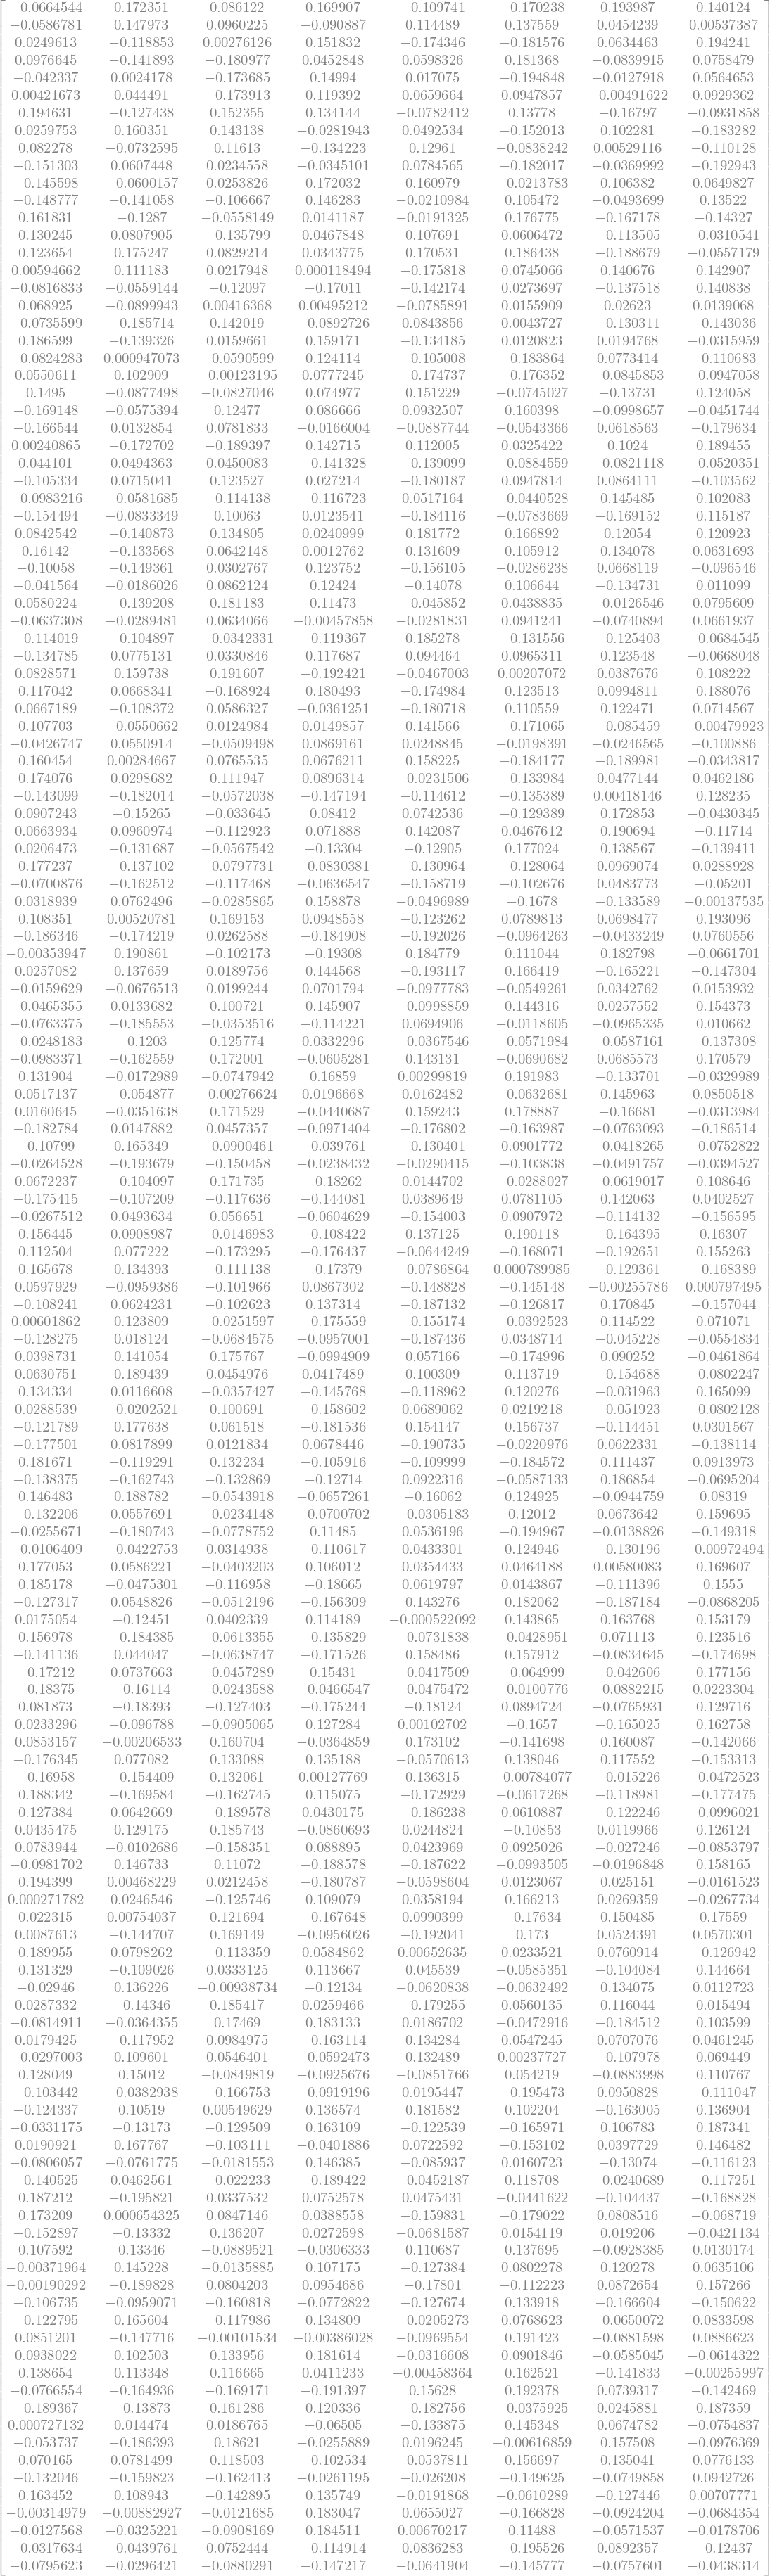

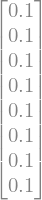

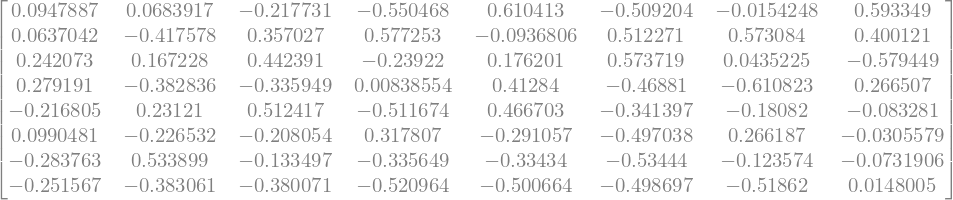

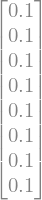

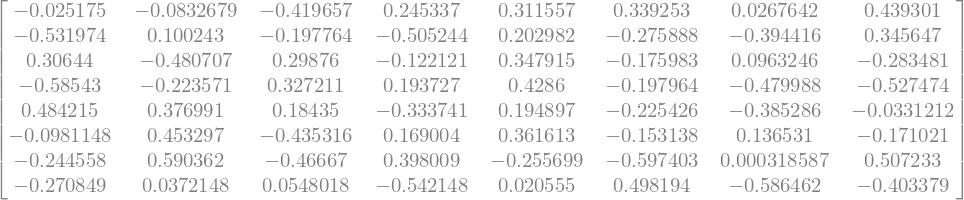

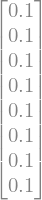

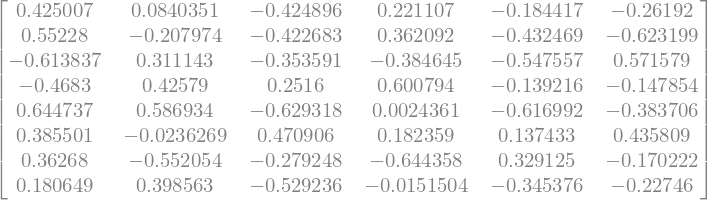

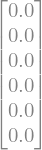

In [289]:
# Note the initializer for the hidden unit bias weights
for i in model.get_weights():
 display(sp.Matrix(i))


In [351]:
# Train it!
history = model.fit(training, output,
 batch_size=1,
 epochs=100,
 verbose=1)

Train on 178 samples
Epoch 1/100
178/178 [==============================] - 1s 4ms/sample - loss: 3.4718 - categorical_accuracy: 0.0337
Epoch 2/100
178/178 [==============================] - 1s 4ms/sample - loss: 3.4414 - categorical_accuracy: 0.0562
Epoch 3/100
178/178 [==============================] - 1s 4ms/sample - loss: 3.3974 - categorical_accuracy: 0.0730
Epoch 4/100
178/178 [==============================] - 1s 4ms/sample - loss: 3.3158 - categorical_accuracy: 0.1292
Epoch 5/100
178/178 [==============================] - 1s 5ms/sample - loss: 3.1724 - categorical_accuracy: 0.1517
Epoch 6/100
178/178 [==============================] - 1s 3ms/sample - loss: 2.9864 - categorical_accuracy: 0.1461
Epoch 7/100
178/178 [==============================] - 1s 5ms/sample - loss: 2.7688 - categorical_accuracy: 0.2079
Epoch 8/100
178/178 [==============================] - 1s 4ms/sample - loss: 2.5435 - categorical_accuracy: 0.2472
Epoch 9/100
178/178 [==============================] - 1s 4

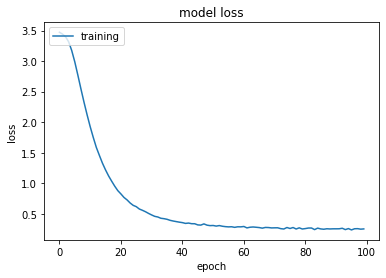

In [352]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper left')
plt.show()

In [354]:
score = model.evaluate(training,output,verbose=1)
print("Loss:",score[0])
print("Accuracy:",score[1])

Loss: 0.19964439580949506
Accuracy: 0.8707865


In [306]:
# save the model .. comment out for now until we train the data appropriately
model.save("model.Chatbot")

In [307]:
def bag_of_words(s, words):
    bag = [0 for _ in range(len(words))]

    s_words = nltk.word_tokenize(s)
    s_words = [stemmer.stem(word.lower()) for word in s_words]

    for se in s_words:
        for i, w in enumerate(words):
            if w == se:
                bag[i] = 1
            
    return numpy.array(bag)




In [308]:
def chat():
    print("Start talking with the bot (type quit to stop)!")
    while True:
        inp = input("You: ")
        if inp.lower() == "quit":
            break

        results = model.predict(np.array([bag_of_words(inp, words)]))
        
        
        
        results_index = numpy.argmax(results)
        tag = labels[results_index]

        for tg in data["intents"]:
            if tg['tag'] == tag:
                responses = tg['responses']

        print(random.choice(responses))



In [ ]:
chat()

Start talking with the bot (type quit to stop)!


You:  hello


Hola human, please tell me your GeniSys user


You:  what


Pearly said I leave him with questions unanswered because I do not know what he is really talking about.


You:  whats your name


I'm Todd!


You:  hi


Hola human, please tell me your GeniSys user


You:  how is your day


Don't EVER speak like that around me


You:  i dont understand


Well I would not be a very clever AI if I did not would I?


You:  what the 


Paul said I not answering his question makes him think I are not going to answer his question.
